In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import ndes.nde as nde
import distributions.priors as priors
import compression.IMNN.IMNN_delfi as IMNN

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
### SET UP FOR SIMULATION CODE ###

# n(z)
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Fiducial power spectrum
C = cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, N)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = cosmic_shear.power_spectrum(theta_plus, pz_fid, modes, np.zeros((nz, nz)))
    Cm = cosmic_shear.power_spectrum(theta_minus, pz_fid, modes, np.zeros((nz, nz)))
    C0 = cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, np.zeros((nz, nz)))

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = cosmic_shear.fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

In [4]:
# Define the simulator function: takes parameters, spits out simulated data
# Should have the form: simulator(parameters, args) -> simulated dataset
simulator = cosmic_shear.simulate
simulator_args = [pz_fid, modes, N, nl]

In [5]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

In [6]:
## Define the compression function: takes data, spits out compressed summaries
## Should have the form compressor(data, args) -> compressed summaries
## NB: compression should be set-up like a quasi maximum-likelihood estimator
der = np.array([0.01, 0.01, 0.005, 0.01, 0.01])
initial_sims = 1000
n_epochs = 100
n = IMNN.get_network(simulator, simulator_args, theta_fiducial, der, initial_sims, "cosmic_shear", make_simulations = False)
IMNN.train_IMNN(n, n_epochs)
compressor = IMNN.IMNN_compressor
compressor_args = n

(1000, 550) (100, 5, 550) (100, 5, 550) (1000, 550) (100, 5, 550) (100, 5, 550)
[550, 275, 137, 68, 34, 17, 8]
saving model as compression/cosmic_shear.meta
saving the graph as compression/cosmic_shear.meta


 28%|██▊       | 28/100 [00:13<00:33,  2.12it/s, lndetF=47.4, lndetF_test=44.6]compression/IMNN/IMNN.py:819: RuntimeWarning: invalid value encountered in float_scalars
  n.history["det(test F)"].append(dettestF[0] * dettestF[1])
100%|██████████| 100/100 [00:39<00:00,  2.51it/s, lndetF=59.7, lndetF_test=58.2]

saving the graph as compression/cosmic_shear.meta


In [9]:
print("Target log(det(F)) = ", np.linalg.slogdet(F)[0] * np.linalg.slogdet(F)[1])
print("IMNN log(det(F)) = ", n.history["det(test F)"][-1])

Target log(det(F)) =  52.110271527263016
IMNN log(det(F)) =  58.236233


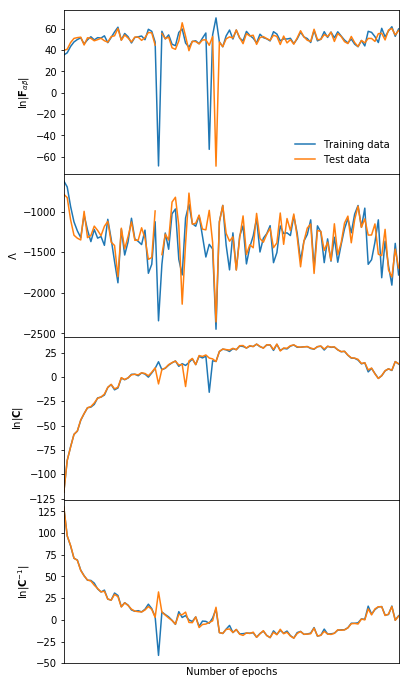

In [10]:
fig, ax = plt.subplots(4, 1, sharex = True, figsize = (6, 12))
plt.subplots_adjust(hspace = 0)
end = len(n.history["det(test F)"])
epochs = np.arange(1, end + 1)
a, = ax[0].plot(epochs, n.history["det(F)"][:end], label = 'Training data')
b, = ax[0].plot(epochs, n.history["det(test F)"][:end], label = 'Test data')
ax[0].legend(frameon = False)
ax[0].set_ylabel(r'$\ln|{\bf F}_{\alpha\beta}|$')
ax[0].set_xticks([])
ax[1].plot(epochs, n.history["Λ"][:end])
ax[1].plot(epochs, n.history["test Λ"][:end])
ax[1].set_xlabel('Number of epochs')
ax[1].set_ylabel(r'$\Lambda$')
ax[1].set_xlim([1, len(epochs)]);
ax[2].plot(epochs, n.history["det(C)"])
ax[2].plot(epochs, n.history["det(test C)"])
ax[2].set_xlabel('Number of epochs')
ax[2].set_ylabel(r'$\ln|{\bf C}|$')
ax[2].set_xlim([1, len(epochs)]);
ax[3].plot(epochs, n.history["det(iC)"])
ax[3].plot(epochs, n.history["det(test iC)"])
ax[3].set_xlabel('Number of epochs')
ax[3].set_ylabel(r'$\ln|{\bf C}^{-1}|$')
ax[3].set_xlim([1, len(epochs)]);

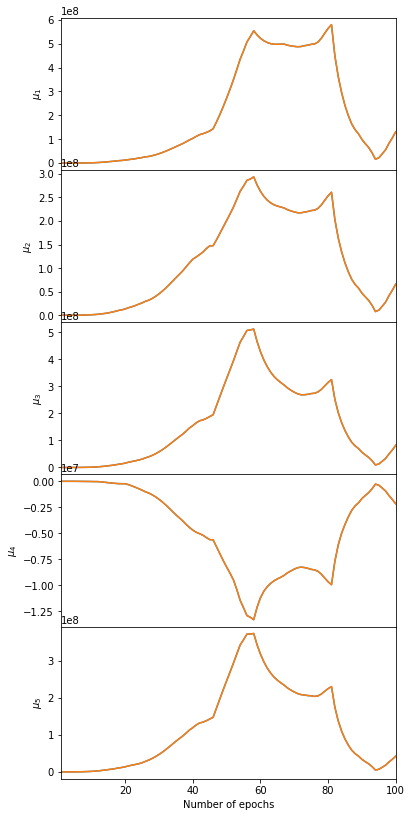

In [11]:
fig, ax = plt.subplots(5, 1, figsize = (6, 14))
plt.subplots_adjust(hspace = 0)
for i in range(5):
    ax[i].plot(epochs, np.array(n.history['μ'])[:, i])
    ax[i].plot(epochs, np.array(n.history['test μ'])[:, i])
    ax[i].set_ylabel("$\mu_{" + str(i + 1) + "}$")
    ax[i].set_xlim([1, len(epochs)])
    if i < 4:
        ax[i].set_xticks([])
    else:
        ax[i].set_xlabel('Number of epochs')

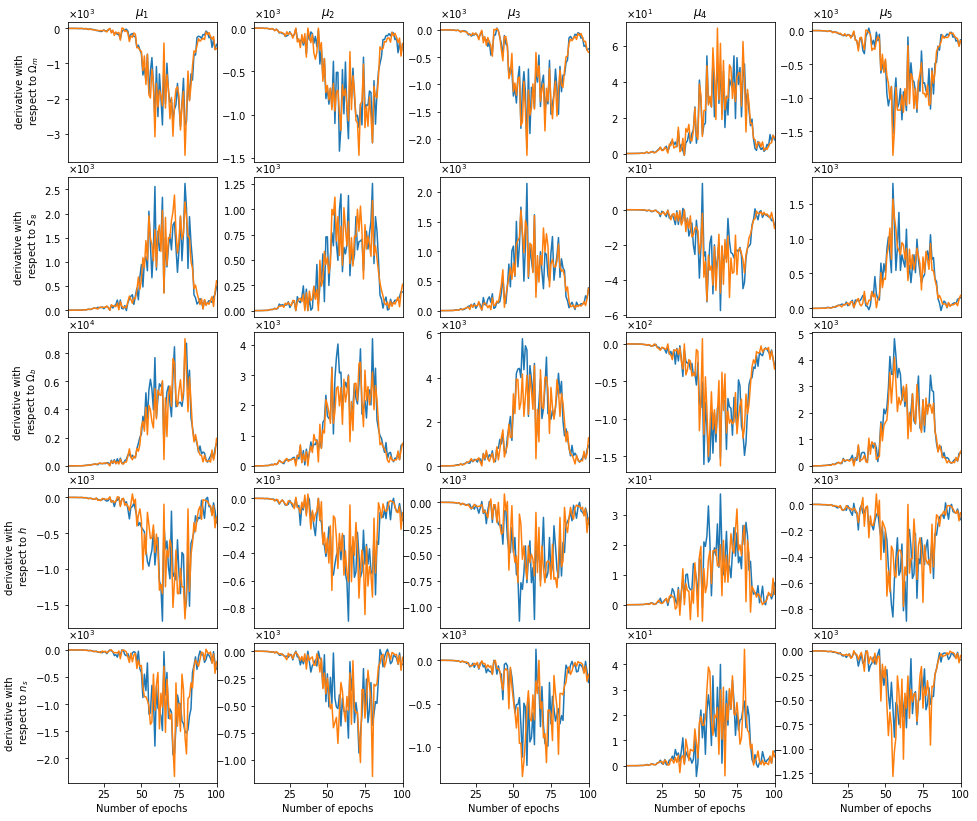

In [12]:
fig, ax = plt.subplots(5, 5, figsize = (16, 14))
plt.subplots_adjust(hspace = 0.11, wspace = 0.25)
plot_labels = ["$\Omega_m$", "$S_8$", "$\Omega_b$", "$h$", "$n_s$"]
for i in range(5):
    for j in range(5):
        ax[i, j].plot(epochs, np.array(n.history['dμdθ'])[:, i, j])
        ax[i, j].plot(epochs, np.array(n.history['test dμdθ'])[:, i, j])
        ax[i, j].set_xlim([1, len(epochs)]);
        ax[i, j].ticklabel_format(axis = "y", style = 'sci', scilimits = (0, 0), useMathText = True)
        if i == 0:
            ax[i, j].set_title("$\mu_{" + str(j + 1) + "}$")
        if i == 4:
            ax[i, j].set_xlabel('Number of epochs')
        if i < 4:
            ax[i, j].set_xticks([])
        if j == 0:
            ax[i, j].set_ylabel("derivative with\n respect to " + plot_labels[i])

In [13]:
import pickle
with open("simulations/cosmic_shear.pickle", "rb") as file:
    data = pickle.load(file)

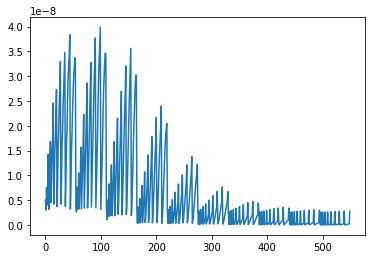

In [14]:
plt.plot(data["x_central"][0])

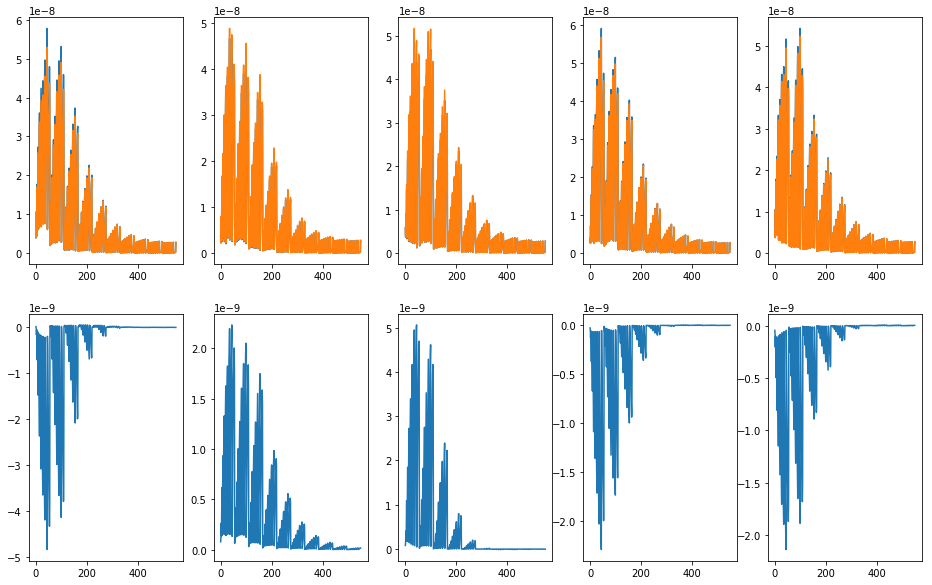

In [15]:
fig, ax = plt.subplots(2, 5, figsize = (16, 10))
#for i in range(len(data["x_m"])):
for j in range(len(data["x_m"][0])):
    ax[0, j].plot(data["x_m"][1, j])
    ax[0, j].plot(data["x_p"][1, j])
    ax[1, j].plot(data["x_p"][1, j] - data["x_m"][1, j])

In [16]:
# Data vector
# Simulate some cosmic shear data
data = simulator(theta_fiducial, simulator_args)
compressed_data = compressor(data, compressor_args)
print("Fiducial parameter values = ", theta_fiducial)
print("IMNN MLE values = ", compressed_data)

Fiducial parameter values =  [0.3  0.8  0.05 0.7  0.96]
IMNN MLE values =  [0.36276507 0.7122044  0.0236202  0.48487553 1.1504616 ]


In [17]:
# Create the DELFI MDN object
n_components = 3
mdn = nde.DelfiMixtureDensityNetwork(compressed_data, prior, [lower, upper], np.linalg.inv(n.sess.run(n.test_F)), theta_fiducial, n_components, n_hidden = [50, 50], activations = [tf.nn.tanh, tf.nn.tanh], names = names, labels = labels, ranges = ranges)

Generating pre-training data...
Training on the pre-training data...



Done.
Sampling approximate posterior...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Done.
Saving fish_pretrain_post.pdf


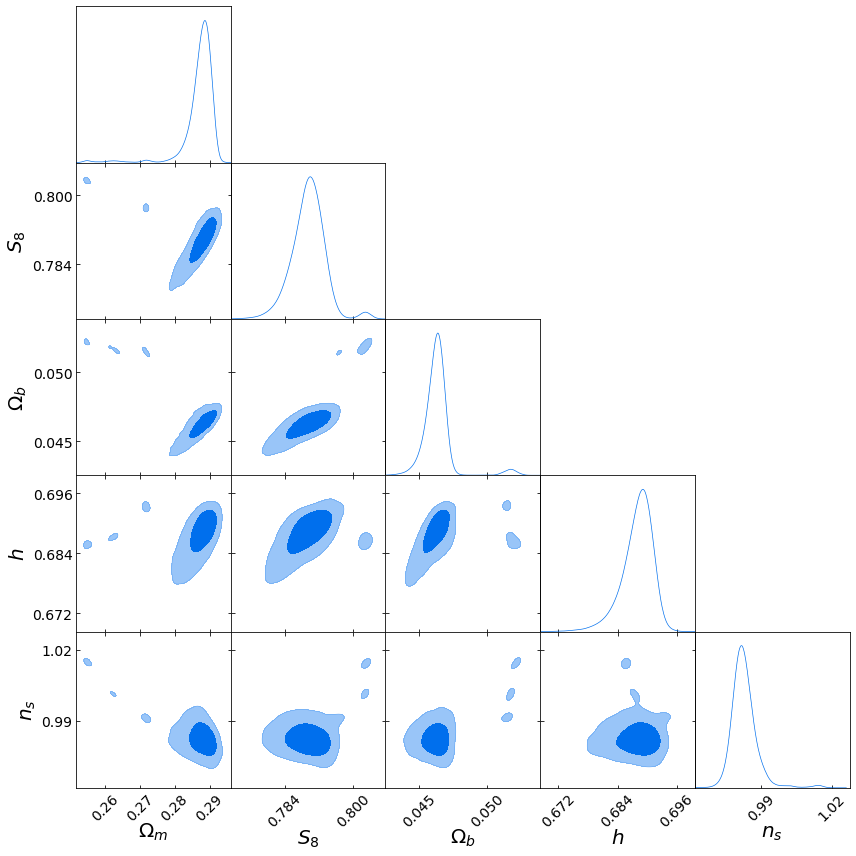

In [18]:
# Do the Fisher pre-training
mdn.sess.run(tf.global_variables_initializer())
mdn.fisher_pretraining(50000, prior, epochs=100, epsilon = 1e-37)

  0%|          | 0/500 [00:00<?, ?it/s]

Running initial 500 sims...


100%|██████████| 500/500 [07:25<00:00,  1.06s/it]

Done.



Sampling approximate posterior...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)


Done.
Saving seq_train_post_0.pdf


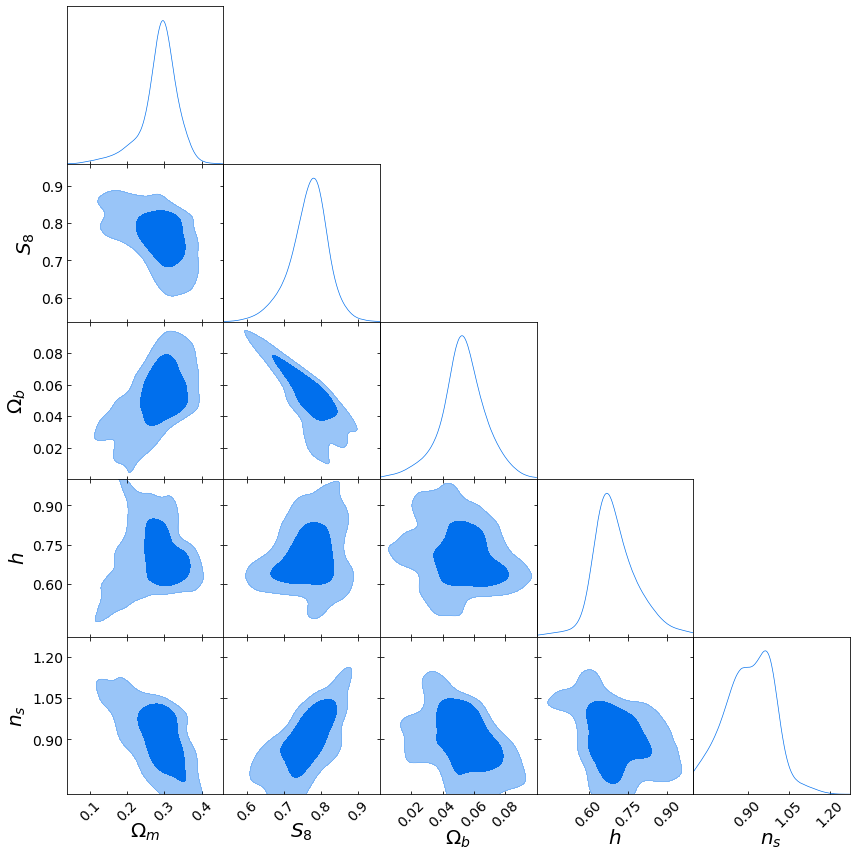

Population 1/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 40%|████      | 200/500 [03:26<04:04,  1.23it/s]

Simulator returns exception for parameter values: [0.13483508 0.88906699 0.03161266 0.5782333  1.21772775] (rank 0)
Simulator returns exception for parameter values: [0.13483508 0.88906699 0.03161266 0.5782333  1.21772775] (rank 0)
Simulator returns exception for parameter values: [0.13483508 0.88906699 0.03161266 0.5782333  1.21772775] (rank 0)


 41%|████      | 206/500 [03:30<02:57,  1.65it/s]

Simulator returns exception for parameter values: [0.1644375  0.83416003 0.04164855 0.57289799 1.14682122] (rank 0)
Simulator returns exception for parameter values: [0.1644375  0.83416003 0.04164855 0.57289799 1.14682122] (rank 0)


 46%|████▌     | 231/500 [03:54<04:31,  1.01s/it]

Simulator returns exception for parameter values: [0.15157509 0.87131848 0.03594121 0.71032392 1.09128799] (rank 0)
Simulator returns exception for parameter values: [0.16946561 0.85721035 0.03993834 0.71448959 1.07320052] (rank 0)
Simulator returns exception for parameter values: [0.16946561 0.85721035 0.03993834 0.71448959 1.07320052] (rank 0)
Simulator returns exception for parameter values: [0.17156863 0.8555184  0.04044422 0.7179643  1.07084338] (rank 0)
Simulator returns exception for parameter values: [0.14826305 0.87073326 0.03772554 0.73690719 1.08370714] (rank 0)
Simulator returns exception for parameter values: [0.14826305 0.87073326 0.03772554 0.73690719 1.08370714] (rank 0)
Simulator returns exception for parameter values: [0.14826305 0.87073326 0.03772554 0.73690719 1.08370714] (rank 0)
Simulator returns exception for parameter values: [0.14826305 0.87073326 0.03772554 0.73690719 1.08370714] (rank 0)
Simulator returns exception for parameter values: [0.14826305 0.87073326

 47%|████▋     | 235/500 [04:02<06:19,  1.43s/it]

Simulator returns exception for parameter values: [0.17501197 0.85629599 0.04057391 0.82787033 0.99727834] (rank 0)
Simulator returns exception for parameter values: [0.17501197 0.85629599 0.04057391 0.82787033 0.99727834] (rank 0)
Simulator returns exception for parameter values: [0.17501197 0.85629599 0.04057391 0.82787033 0.99727834] (rank 0)
Simulator returns exception for parameter values: [0.17271427 0.85944002 0.0419898  0.82643293 1.00447163] (rank 0)
Simulator returns exception for parameter values: [0.17271427 0.85944002 0.0419898  0.82643293 1.00447163] (rank 0)
Simulator returns exception for parameter values: [0.17271427 0.85944002 0.0419898  0.82643293 1.00447163] (rank 0)


 48%|████▊     | 239/500 [04:08<05:36,  1.29s/it]

Simulator returns exception for parameter values: [0.15427483 0.8749478  0.04025839 0.76777353 1.05165221] (rank 0)
Simulator returns exception for parameter values: [0.15427483 0.8749478  0.04025839 0.76777353 1.05165221] (rank 0)
Simulator returns exception for parameter values: [0.15427483 0.8749478  0.04025839 0.76777353 1.05165221] (rank 0)
Simulator returns exception for parameter values: [0.15427483 0.8749478  0.04025839 0.76777353 1.05165221] (rank 0)
Simulator returns exception for parameter values: [0.16145713 0.86999885 0.04114076 0.7636398  1.04767497] (rank 0)
Simulator returns exception for parameter values: [0.16145713 0.86999885 0.04114076 0.7636398  1.04767497] (rank 0)
Simulator returns exception for parameter values: [0.16145713 0.86999885 0.04114076 0.7636398  1.04767497] (rank 0)
Simulator returns exception for parameter values: [0.16145713 0.86999885 0.04114076 0.7636398  1.04767497] (rank 0)
Simulator returns exception for parameter values: [0.16602263 0.86237647

100%|██████████| 500/500 [08:22<00:00,  2.00it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_1.pdf


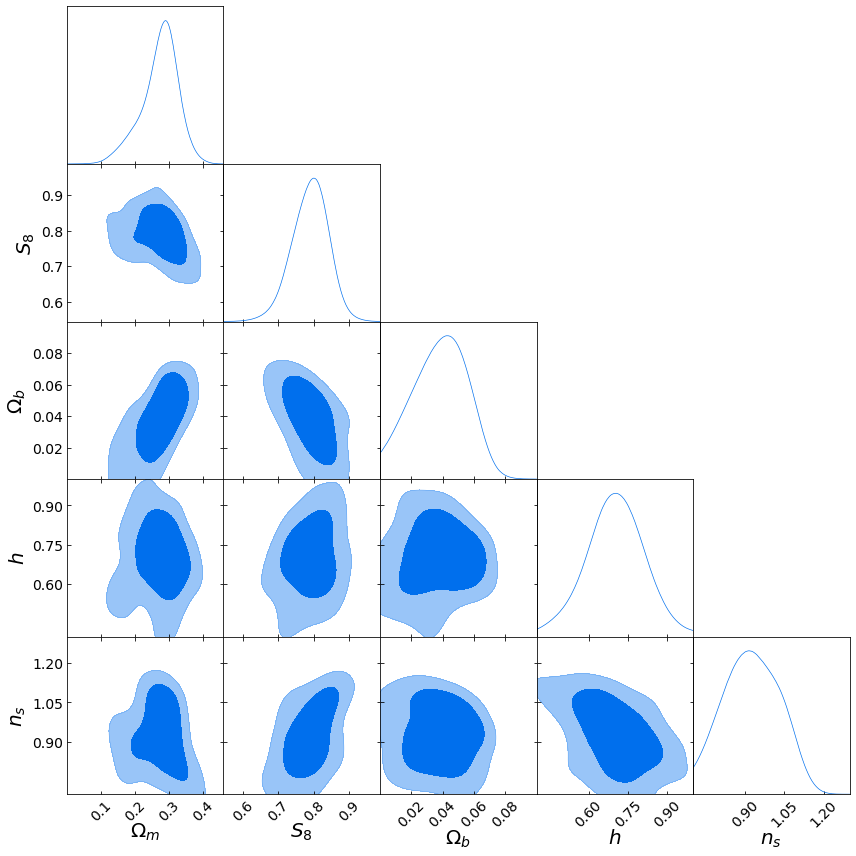

Population 2/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


100%|██████████| 500/500 [04:31<00:00,  1.80it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_2.pdf


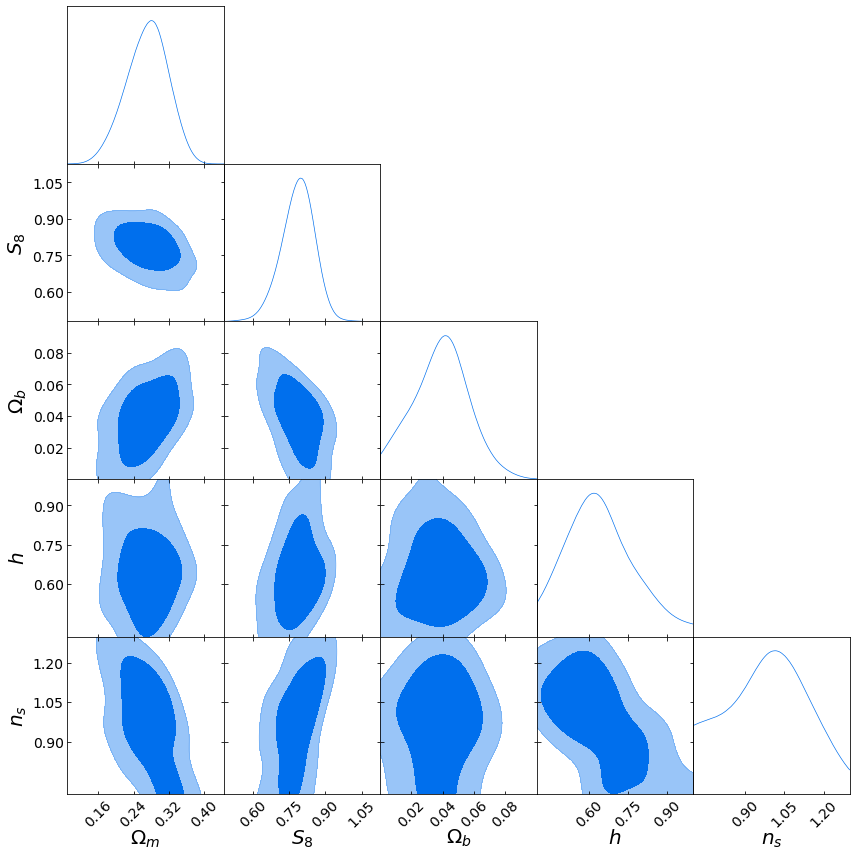

Population 3/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


  4%|▍         | 20/500 [00:08<03:33,  2.25it/s]

Simulator returns exception for parameter values: [0.15931935 0.77310239 0.03068807 0.46957309 1.18539201] (rank 0)
Simulator returns exception for parameter values: [0.15931935 0.77310239 0.03068807 0.46957309 1.18539201] (rank 0)
Simulator returns exception for parameter values: [0.15931935 0.77310239 0.03068807 0.46957309 1.18539201] (rank 0)
Simulator returns exception for parameter values: [0.13800115 0.78436697 0.02706777 0.44977068 1.22538643] (rank 0)
Simulator returns exception for parameter values: [0.13800115 0.78436697 0.02706777 0.44977068 1.22538643] (rank 0)


  7%|▋         | 35/500 [00:18<05:49,  1.33it/s]

Simulator returns exception for parameter values: [0.1773319  0.89172731 0.00392523 0.545299   1.12128892] (rank 0)
Simulator returns exception for parameter values: [0.17856021 0.89019496 0.0044895  0.547839   1.11801414] (rank 0)
Simulator returns exception for parameter values: [0.17856021 0.89019496 0.0044895  0.547839   1.11801414] (rank 0)
Simulator returns exception for parameter values: [0.17856021 0.89019496 0.0044895  0.547839   1.11801414] (rank 0)
Simulator returns exception for parameter values: [0.18136424 0.88503295 0.00514071 0.54641524 1.10966975] (rank 0)
Simulator returns exception for parameter values: [0.18136424 0.88503295 0.00514071 0.54641524 1.10966975] (rank 0)
Simulator returns exception for parameter values: [0.18136424 0.88503295 0.00514071 0.54641524 1.10966975] (rank 0)


  9%|▉         | 46/500 [00:24<03:31,  2.15it/s]

Simulator returns exception for parameter values: [0.16230551 0.82660378 0.00920797 0.5263438  1.06641755] (rank 0)
Simulator returns exception for parameter values: [0.13084949 0.85429657 0.00200925 0.49016564 1.12209327] (rank 0)
Simulator returns exception for parameter values: [0.13084949 0.85429657 0.00200925 0.49016564 1.12209327] (rank 0)


 10%|▉         | 48/500 [00:25<04:06,  1.83it/s]

Simulator returns exception for parameter values: [0.17609347 0.80671846 0.00973948 0.48668672 1.04764134] (rank 0)
Simulator returns exception for parameter values: [0.14977486 0.83360068 0.0069705  0.48356808 1.12399497] (rank 0)
Simulator returns exception for parameter values: [0.14977486 0.83360068 0.0069705  0.48356808 1.12399497] (rank 0)
Simulator returns exception for parameter values: [0.14977486 0.83360068 0.0069705  0.48356808 1.12399497] (rank 0)
Simulator returns exception for parameter values: [0.14977486 0.83360068 0.0069705  0.48356808 1.12399497] (rank 0)
Simulator returns exception for parameter values: [0.15993352 0.84024109 0.01619973 0.54891485 1.12279997] (rank 0)
Simulator returns exception for parameter values: [0.15993352 0.84024109 0.01619973 0.54891485 1.12279997] (rank 0)
Simulator returns exception for parameter values: [0.12447934 0.85271895 0.01500871 0.56086617 1.15929765] (rank 0)
Simulator returns exception for parameter values: [0.12447934 0.85271895

 10%|█         | 50/500 [00:30<09:26,  1.26s/it]

Simulator returns exception for parameter values: [0.11737269 0.88098424 0.01230675 0.50186758 1.23100543] (rank 0)


 11%|█         | 55/500 [00:34<06:38,  1.12it/s]

Simulator returns exception for parameter values: [0.13599926 0.83971961 0.02506963 0.50350543 1.19804938] (rank 0)
Simulator returns exception for parameter values: [0.13599926 0.83971961 0.02506963 0.50350543 1.19804938] (rank 0)
Simulator returns exception for parameter values: [0.13599926 0.83971961 0.02506963 0.50350543 1.19804938] (rank 0)
Simulator returns exception for parameter values: [0.13886017 0.82875104 0.02639141 0.50672948 1.18780735] (rank 0)
Simulator returns exception for parameter values: [0.13886017 0.82875104 0.02639141 0.50672948 1.18780735] (rank 0)


 58%|█████▊    | 291/500 [02:34<01:54,  1.83it/s]

Simulator returns exception for parameter values: [0.18208387 0.8947297  0.00875041 0.75224093 1.14952808] (rank 0)
Simulator returns exception for parameter values: [0.18208387 0.8947297  0.00875041 0.75224093 1.14952808] (rank 0)
Simulator returns exception for parameter values: [0.18208387 0.8947297  0.00875041 0.75224093 1.14952808] (rank 0)
Simulator returns exception for parameter values: [0.18208387 0.8947297  0.00875041 0.75224093 1.14952808] (rank 0)
Simulator returns exception for parameter values: [0.18307737 0.89413938 0.00898429 0.7521929  1.14748056] (rank 0)
Simulator returns exception for parameter values: [0.18307737 0.89413938 0.00898429 0.7521929  1.14748056] (rank 0)
Simulator returns exception for parameter values: [0.17775249 0.89582972 0.0094557  0.74701926 1.16622473] (rank 0)
Simulator returns exception for parameter values: [0.17356626 0.90148156 0.00843742 0.74406395 1.18678455] (rank 0)
Simulator returns exception for parameter values: [0.17356626 0.90148156

 58%|█████▊    | 292/500 [02:38<05:12,  1.50s/it]

Simulator returns exception for parameter values: [0.17918578 0.93227036 0.01872036 0.66160643 1.29432921] (rank 0)
Simulator returns exception for parameter values: [0.17918578 0.93227036 0.01872036 0.66160643 1.29432921] (rank 0)


 96%|█████████▌| 479/500 [04:12<00:09,  2.19it/s]

Simulator returns exception for parameter values: [0.22007924 0.98156535 0.00131968 0.94364817 1.04902489] (rank 0)
Simulator returns exception for parameter values: [0.22007924 0.98156535 0.00131968 0.94364817 1.04902489] (rank 0)
Simulator returns exception for parameter values: [0.22007924 0.98156535 0.00131968 0.94364817 1.04902489] (rank 0)
Simulator returns exception for parameter values: [0.22007924 0.98156535 0.00131968 0.94364817 1.04902489] (rank 0)


 96%|█████████▌| 480/500 [04:14<00:17,  1.12it/s]

Simulator returns exception for parameter values: [0.23024991 1.0229877  0.00293697 0.96732184 1.04961657] (rank 0)
Simulator returns exception for parameter values: [0.23024991 1.0229877  0.00293697 0.96732184 1.04961657] (rank 0)


100%|██████████| 500/500 [04:24<00:00,  2.17it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_3.pdf


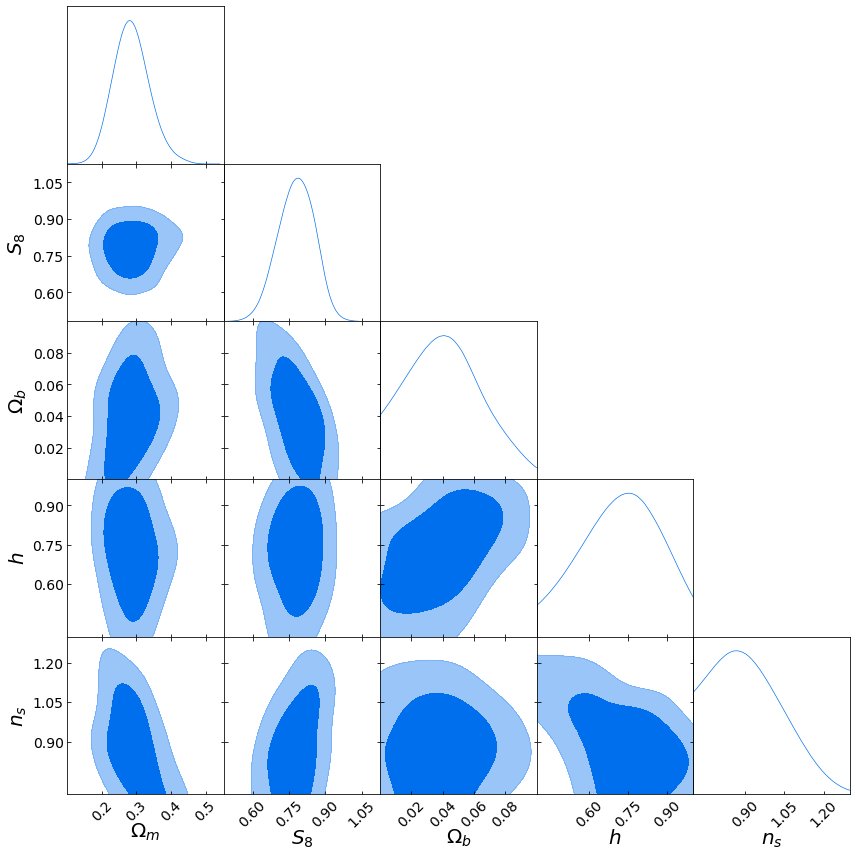

Population 4/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


100%|██████████| 500/500 [04:17<00:00,  2.07it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_4.pdf


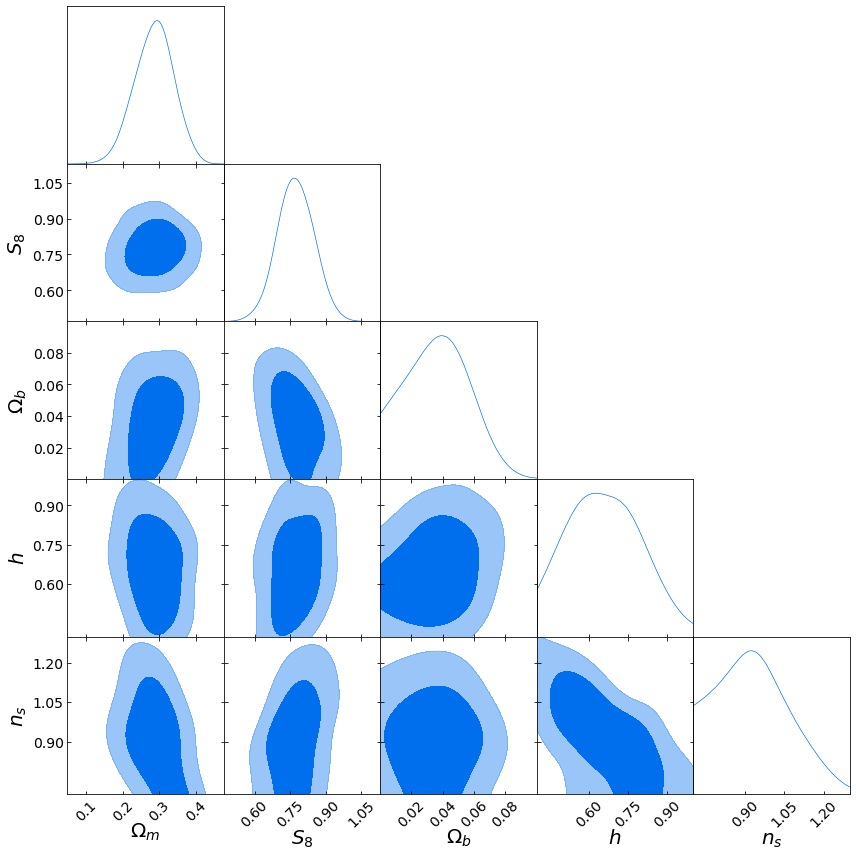

Population 5/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 60%|██████    | 302/500 [02:33<01:32,  2.13it/s]

Simulator returns exception for parameter values: [0.18141499 0.81286289 0.00615727 0.5850449  0.95798668] (rank 0)


100%|██████████| 500/500 [04:14<00:00,  2.12it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_5.pdf


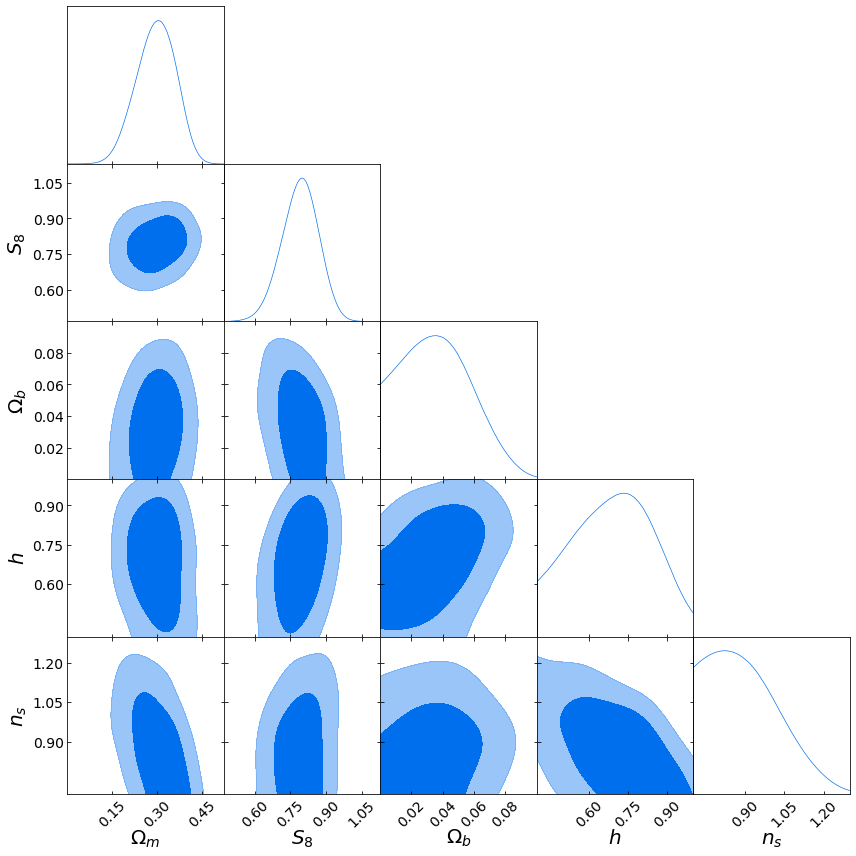

Population 6/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 79%|███████▉  | 394/500 [03:26<00:50,  2.12it/s]

Simulator returns exception for parameter values: [0.14034033 0.81597763 0.08270012 0.95456423 1.21608293] (rank 0)
Simulator returns exception for parameter values: [0.141386   0.81512554 0.08159014 0.95029471 1.20947602] (rank 0)
Simulator returns exception for parameter values: [0.141386   0.81512554 0.08159014 0.95029471 1.20947602] (rank 0)
Simulator returns exception for parameter values: [0.141386   0.81512554 0.08159014 0.95029471 1.20947602] (rank 0)


100%|██████████| 500/500 [04:25<00:00,  1.92it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_6.pdf


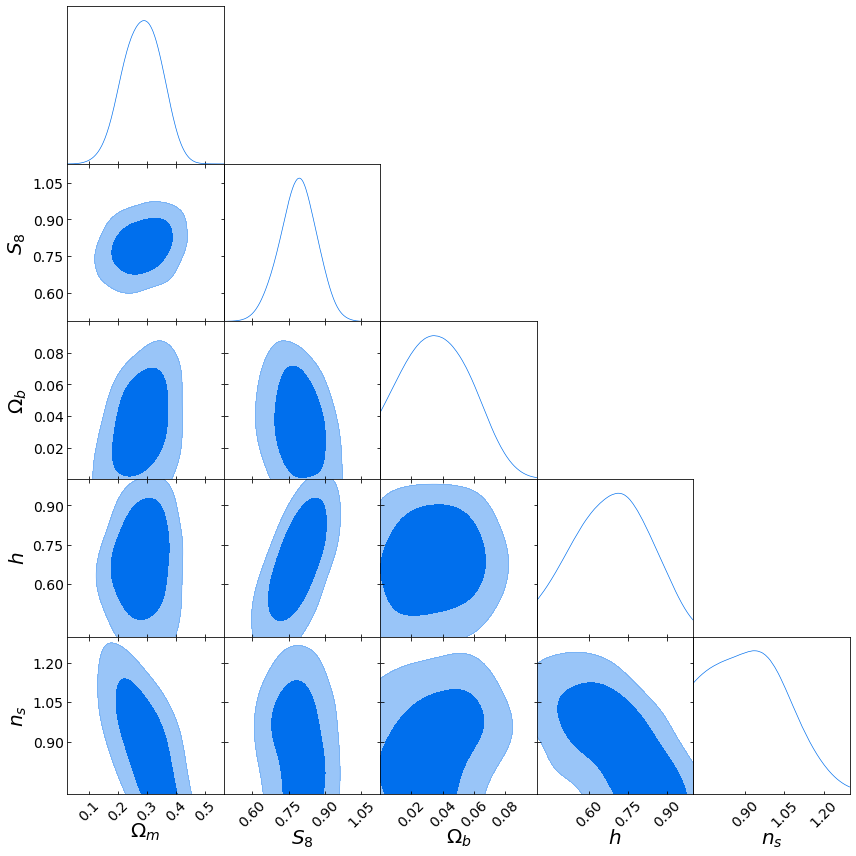

Population 7/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


  4%|▍         | 21/500 [00:12<05:07,  1.56it/s]

Simulator returns exception for parameter values: [0.14732289 0.82825663 0.01521399 0.53530588 1.2237173 ] (rank 0)
Simulator returns exception for parameter values: [0.14732289 0.82825663 0.01521399 0.53530588 1.2237173 ] (rank 0)


  8%|▊         | 40/500 [00:23<03:29,  2.20it/s]

Simulator returns exception for parameter values: [0.18031452 0.88781319 0.02994308 0.64438829 1.23999467] (rank 0)
Simulator returns exception for parameter values: [0.18031452 0.88781319 0.02994308 0.64438829 1.23999467] (rank 0)


  9%|▊         | 43/500 [00:25<04:50,  1.57it/s]

Simulator returns exception for parameter values: [0.17081961 0.93557047 0.038654   0.73103399 1.26525515] (rank 0)
Simulator returns exception for parameter values: [0.17060658 0.93329093 0.0370356  0.72257828 1.26194833] (rank 0)
Simulator returns exception for parameter values: [0.17060658 0.93329093 0.0370356  0.72257828 1.26194833] (rank 0)
Simulator returns exception for parameter values: [0.17060658 0.93329093 0.0370356  0.72257828 1.26194833] (rank 0)
Simulator returns exception for parameter values: [0.17246501 0.91968304 0.03593562 0.72220088 1.23174961] (rank 0)


 12%|█▏        | 60/500 [00:34<03:13,  2.27it/s]

Simulator returns exception for parameter values: [0.12881504 0.84673895 0.01833106 0.66426829 1.25744026] (rank 0)
Simulator returns exception for parameter values: [0.12881504 0.84673895 0.01833106 0.66426829 1.25744026] (rank 0)
Simulator returns exception for parameter values: [0.12881504 0.84673895 0.01833106 0.66426829 1.25744026] (rank 0)
Simulator returns exception for parameter values: [0.12881504 0.84673895 0.01833106 0.66426829 1.25744026] (rank 0)
Simulator returns exception for parameter values: [0.12881504 0.84673895 0.01833106 0.66426829 1.25744026] (rank 0)
Simulator returns exception for parameter values: [0.12881504 0.84673895 0.01833106 0.66426829 1.25744026] (rank 0)
Simulator returns exception for parameter values: [0.15381388 0.8164854  0.02227972 0.63081419 1.20671544] (rank 0)
Simulator returns exception for parameter values: [0.15381388 0.8164854  0.02227972 0.63081419 1.20671544] (rank 0)
Simulator returns exception for parameter values: [0.15381388 0.8164854 

 68%|██████▊   | 339/500 [03:05<01:14,  2.16it/s]

Simulator returns exception for parameter values: [0.13136175 0.89777199 0.05369158 0.9663973  1.23978862] (rank 0)
Simulator returns exception for parameter values: [0.13136175 0.89777199 0.05369158 0.9663973  1.23978862] (rank 0)


 68%|██████▊   | 340/500 [03:06<01:29,  1.79it/s]

Simulator returns exception for parameter values: [0.17228487 0.87377069 0.05578669 0.91714022 1.18813004] (rank 0)
Simulator returns exception for parameter values: [0.17228487 0.87377069 0.05578669 0.91714022 1.18813004] (rank 0)
Simulator returns exception for parameter values: [0.17228487 0.87377069 0.05578669 0.91714022 1.18813004] (rank 0)


 88%|████████▊ | 442/500 [04:10<00:29,  1.95it/s]

Simulator returns exception for parameter values: [0.1764838  0.80621705 0.01267002 0.7762719  0.85620645] (rank 0)
Simulator returns exception for parameter values: [0.17861395 0.80621414 0.01306745 0.78020411 0.85477629] (rank 0)
Simulator returns exception for parameter values: [0.17861395 0.80621414 0.01306745 0.78020411 0.85477629] (rank 0)


 89%|████████▉ | 445/500 [04:12<00:34,  1.58it/s]

Simulator returns exception for parameter values: [0.17146638 0.81146991 0.01002492 0.77673109 0.86120041] (rank 0)


100%|██████████| 500/500 [04:42<00:00,  2.06it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_7.pdf


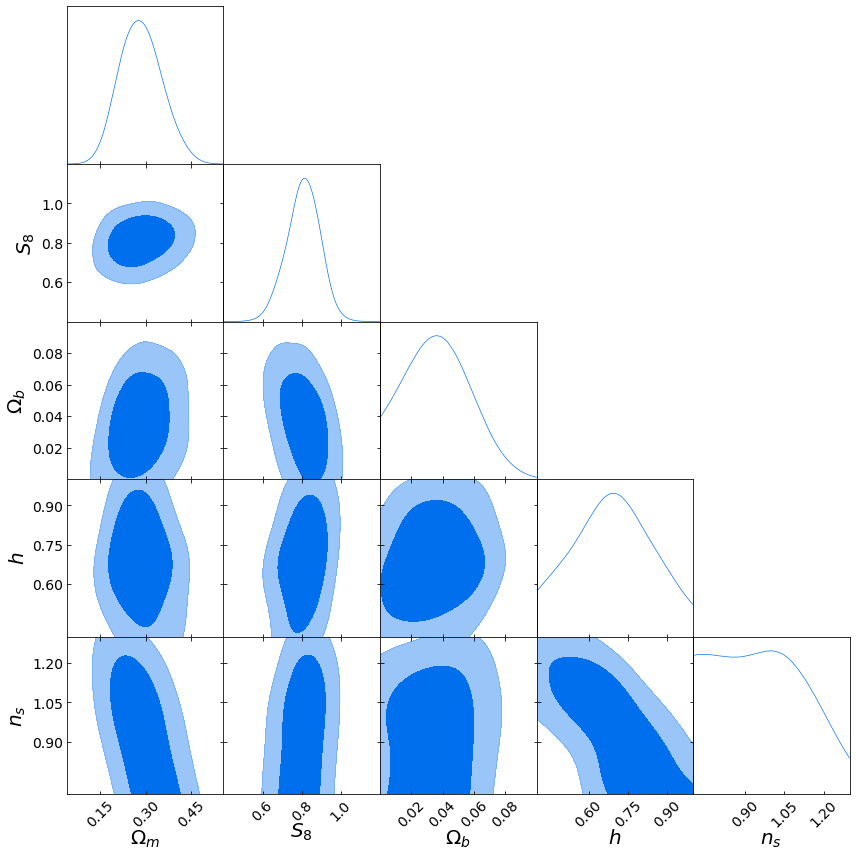

Population 8/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 21%|██        | 104/500 [01:08<03:04,  2.15it/s]

Simulator returns exception for parameter values: [0.1483763  0.73384749 0.01328532 0.43026599 1.15196293] (rank 0)
Simulator returns exception for parameter values: [0.1483763  0.73384749 0.01328532 0.43026599 1.15196293] (rank 0)


 25%|██▍       | 123/500 [01:20<05:29,  1.15it/s]

Simulator returns exception for parameter values: [0.16688224 0.799538   0.04047535 0.64082427 1.06869277] (rank 0)
Simulator returns exception for parameter values: [0.15824129 0.79916464 0.03863694 0.6420961  1.06455592] (rank 0)
Simulator returns exception for parameter values: [0.14881013 0.77540677 0.03361148 0.66535557 1.06372743] (rank 0)
Simulator returns exception for parameter values: [0.15774088 0.79790406 0.03837029 0.64333023 1.06451196] (rank 0)
Simulator returns exception for parameter values: [0.15774088 0.79790406 0.03837029 0.64333023 1.06451196] (rank 0)
Simulator returns exception for parameter values: [0.15774088 0.79790406 0.03837029 0.64333023 1.06451196] (rank 0)
Simulator returns exception for parameter values: [0.15774088 0.79790406 0.03837029 0.64333023 1.06451196] (rank 0)
Simulator returns exception for parameter values: [0.15774088 0.79790406 0.03837029 0.64333023 1.06451196] (rank 0)
Simulator returns exception for parameter values: [0.15774088 0.79790406

 40%|████      | 200/500 [02:17<03:26,  1.45it/s]

Simulator returns exception for parameter values: [0.158004   0.84294257 0.00528362 0.68026704 1.04114422] (rank 0)
Simulator returns exception for parameter values: [0.14194227 0.84500641 0.0021229  0.67795893 1.05928379] (rank 0)
Simulator returns exception for parameter values: [0.14194227 0.84500641 0.0021229  0.67795893 1.05928379] (rank 0)
Simulator returns exception for parameter values: [0.14194227 0.84500641 0.0021229  0.67795893 1.05928379] (rank 0)
Simulator returns exception for parameter values: [0.14194227 0.84500641 0.0021229  0.67795893 1.05928379] (rank 0)
Simulator returns exception for parameter values: [0.14194227 0.84500641 0.0021229  0.67795893 1.05928379] (rank 0)
Simulator returns exception for parameter values: [0.14194227 0.84500641 0.0021229  0.67795893 1.05928379] (rank 0)
Simulator returns exception for parameter values: [0.14194227 0.84500641 0.0021229  0.67795893 1.05928379] (rank 0)
Simulator returns exception for parameter values: [0.14194227 0.84500641

 40%|████      | 202/500 [02:21<06:50,  1.38s/it]

Simulator returns exception for parameter values: [0.14584163 0.79120871 0.01726665 0.64029898 1.10100609] (rank 0)
Simulator returns exception for parameter values: [0.14891125 0.79349805 0.01703081 0.64078334 1.09806379] (rank 0)
Simulator returns exception for parameter values: [0.14891125 0.79349805 0.01703081 0.64078334 1.09806379] (rank 0)
Simulator returns exception for parameter values: [0.14891125 0.79349805 0.01703081 0.64078334 1.09806379] (rank 0)
Simulator returns exception for parameter values: [0.14891125 0.79349805 0.01703081 0.64078334 1.09806379] (rank 0)
Simulator returns exception for parameter values: [0.09150618 0.79768768 0.00774015 0.58998777 1.21914546] (rank 0)
Simulator returns exception for parameter values: [0.08019483 0.796619   0.00616761 0.5896974  1.23051089] (rank 0)
Simulator returns exception for parameter values: [0.08019483 0.796619   0.00616761 0.5896974  1.23051089] (rank 0)
Simulator returns exception for parameter values: [0.08229157 0.79728206

 56%|█████▋    | 282/500 [03:07<01:47,  2.03it/s]

Simulator returns exception for parameter values: [0.15485685 0.74082177 0.01107466 0.55824286 1.09601976] (rank 0)
Simulator returns exception for parameter values: [0.15485685 0.74082177 0.01107466 0.55824286 1.09601976] (rank 0)
Simulator returns exception for parameter values: [0.15485685 0.74082177 0.01107466 0.55824286 1.09601976] (rank 0)
Simulator returns exception for parameter values: [0.13952928 0.73091692 0.00190035 0.51009469 1.12504523] (rank 0)
Simulator returns exception for parameter values: [1.33225063e-01 7.23316303e-01 3.86089855e-04 4.94289963e-01
 1.13751120e+00] (rank 0)
Simulator returns exception for parameter values: [1.33225063e-01 7.23316303e-01 3.86089855e-04 4.94289963e-01
 1.13751120e+00] (rank 0)
Simulator returns exception for parameter values: [1.33225063e-01 7.23316303e-01 3.86089855e-04 4.94289963e-01
 1.13751120e+00] (rank 0)
Simulator returns exception for parameter values: [1.33225063e-01 7.23316303e-01 3.86089855e-04 4.94289963e-01
 1.13751120e+0

 58%|█████▊    | 291/500 [03:13<01:47,  1.95it/s]

Simulator returns exception for parameter values: [0.13736464 0.78942304 0.00441406 0.41119095 1.29772215] (rank 0)
Simulator returns exception for parameter values: [0.13736464 0.78942304 0.00441406 0.41119095 1.29772215] (rank 0)


 63%|██████▎   | 314/500 [03:25<01:33,  1.99it/s]

Simulator returns exception for parameter values: [0.17452442 0.86194954 0.01281983 0.66218153 1.10330198] (rank 0)


 63%|██████▎   | 315/500 [03:25<01:42,  1.80it/s]

Simulator returns exception for parameter values: [0.16741639 0.83923491 0.01741989 0.66674879 1.09661806] (rank 0)
Simulator returns exception for parameter values: [0.1615634  0.83138237 0.02079072 0.69297757 1.06490449] (rank 0)
Simulator returns exception for parameter values: [0.10829754 0.78913378 0.01064065 0.65571625 1.09844927] (rank 0)


100%|██████████| 500/500 [05:18<00:00,  2.13it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_8.pdf


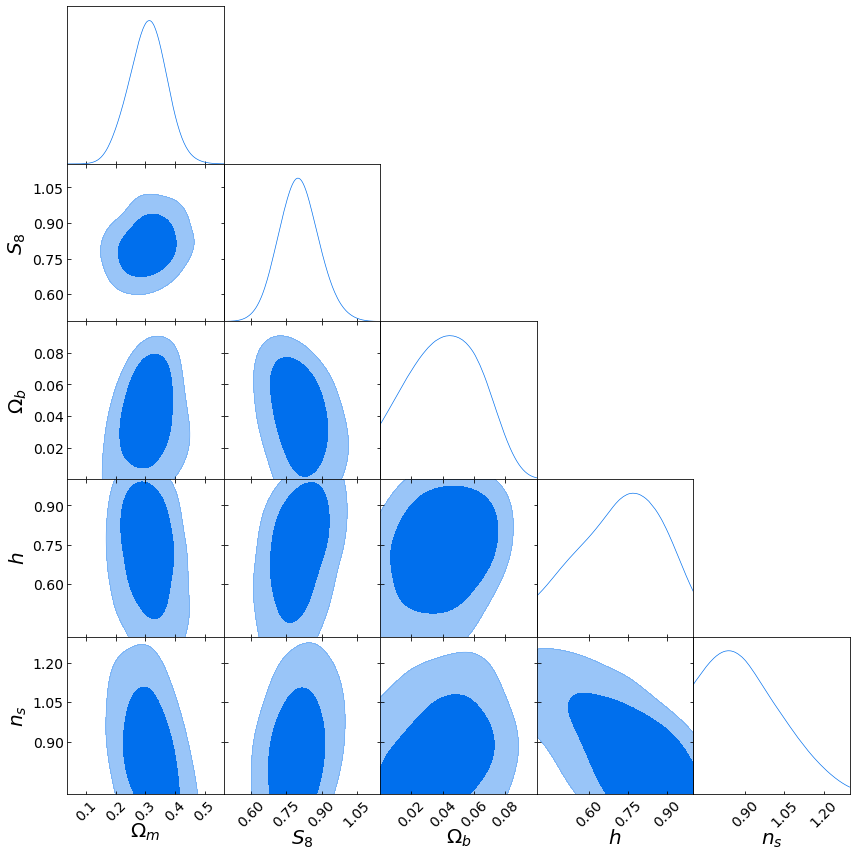

Population 9/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


100%|██████████| 500/500 [04:58<00:00,  1.93it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_9.pdf


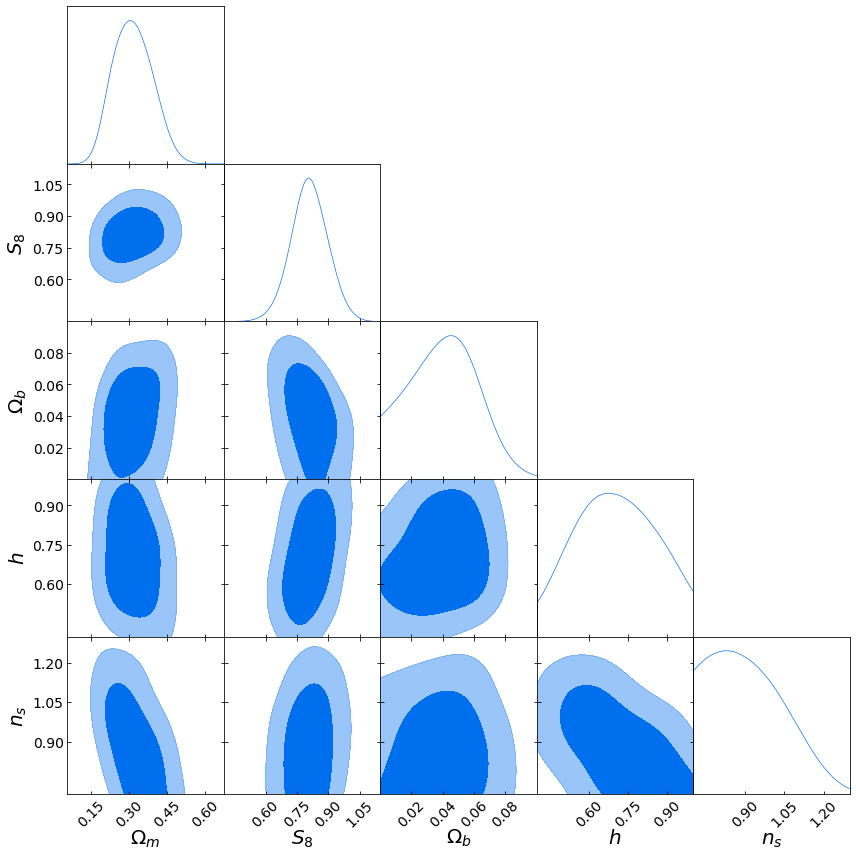

Population 10/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 23%|██▎       | 113/500 [01:24<06:18,  1.02it/s]

Simulator returns exception for parameter values: [0.18836775 0.91661451 0.01702054 0.58825084 1.24339637] (rank 0)
Simulator returns exception for parameter values: [0.18836775 0.91661451 0.01702054 0.58825084 1.24339637] (rank 0)
Simulator returns exception for parameter values: [0.18836775 0.91661451 0.01702054 0.58825084 1.24339637] (rank 0)


 23%|██▎       | 117/500 [01:29<06:56,  1.09s/it]

Simulator returns exception for parameter values: [0.17889234 0.92882327 0.00440639 0.67421082 1.14123395] (rank 0)
Simulator returns exception for parameter values: [0.17889234 0.92882327 0.00440639 0.67421082 1.14123395] (rank 0)
Simulator returns exception for parameter values: [0.17889234 0.92882327 0.00440639 0.67421082 1.14123395] (rank 0)
Simulator returns exception for parameter values: [0.17889234 0.92882327 0.00440639 0.67421082 1.14123395] (rank 0)
Simulator returns exception for parameter values: [0.17889234 0.92882327 0.00440639 0.67421082 1.14123395] (rank 0)


 24%|██▎       | 118/500 [01:32<10:45,  1.69s/it]

Simulator returns exception for parameter values: [0.14018911 0.8954866  0.00297295 0.68852633 1.17059678] (rank 0)
Simulator returns exception for parameter values: [0.14018911 0.8954866  0.00297295 0.68852633 1.17059678] (rank 0)
Simulator returns exception for parameter values: [0.14018911 0.8954866  0.00297295 0.68852633 1.17059678] (rank 0)
Simulator returns exception for parameter values: [0.16025287 0.86868895 0.00475017 0.66197819 1.12828712] (rank 0)
Simulator returns exception for parameter values: [0.16025287 0.86868895 0.00475017 0.66197819 1.12828712] (rank 0)
Simulator returns exception for parameter values: [0.15118278 0.88489507 0.00477945 0.66482895 1.16366388] (rank 0)
Simulator returns exception for parameter values: [0.15118278 0.88489507 0.00477945 0.66482895 1.16366388] (rank 0)
Simulator returns exception for parameter values: [0.15118278 0.88489507 0.00477945 0.66482895 1.16366388] (rank 0)


 27%|██▋       | 136/500 [01:47<03:15,  1.86it/s]

Simulator returns exception for parameter values: [0.1453833  0.78559518 0.03569907 0.44313048 1.24124063] (rank 0)
Simulator returns exception for parameter values: [0.1453833  0.78559518 0.03569907 0.44313048 1.24124063] (rank 0)
Simulator returns exception for parameter values: [0.1453833  0.78559518 0.03569907 0.44313048 1.24124063] (rank 0)
Simulator returns exception for parameter values: [0.14682853 0.78304477 0.03628305 0.46829321 1.22380522] (rank 0)
Simulator returns exception for parameter values: [0.14682853 0.78304477 0.03628305 0.46829321 1.22380522] (rank 0)


 41%|████      | 206/500 [02:41<02:18,  2.12it/s]

Simulator returns exception for parameter values: [2.06806997e-01 9.42789475e-01 3.12569231e-04 6.71758225e-01
 1.11168764e+00] (rank 0)


100%|██████████| 500/500 [06:05<00:00,  1.02s/it]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_10.pdf


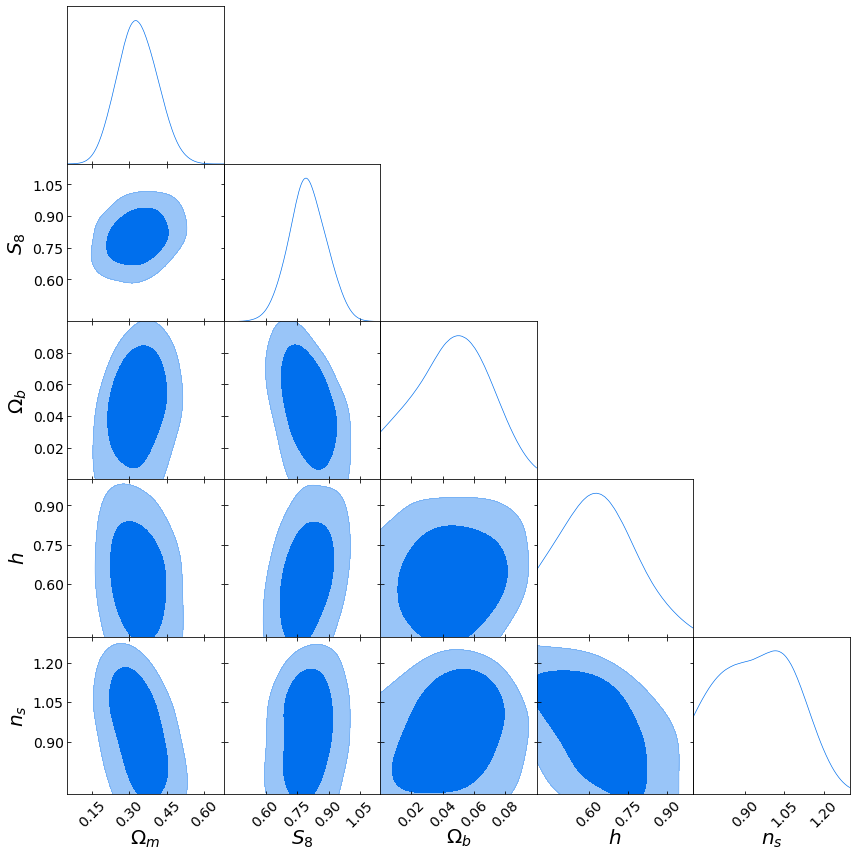

Population 11/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


  9%|▉         | 46/500 [00:34<03:45,  2.01it/s]

Simulator returns exception for parameter values: [0.15972426 0.85919725 0.01997268 0.78300608 1.09495454] (rank 0)
Simulator returns exception for parameter values: [0.15972426 0.85919725 0.01997268 0.78300608 1.09495454] (rank 0)
Simulator returns exception for parameter values: [0.16759625 0.8577796  0.01972962 0.77046322 1.09030011] (rank 0)
Simulator returns exception for parameter values: [0.16759625 0.8577796  0.01972962 0.77046322 1.09030011] (rank 0)


 11%|█▏        | 57/500 [00:40<03:40,  2.01it/s]

Simulator returns exception for parameter values: [0.12240538 0.75172137 0.03530531 0.65808039 1.21614776] (rank 0)
Simulator returns exception for parameter values: [0.12240538 0.75172137 0.03530531 0.65808039 1.21614776] (rank 0)


 38%|███▊      | 191/500 [02:05<02:32,  2.03it/s]

Simulator returns exception for parameter values: [0.16476811 0.72483329 0.07261213 0.79000853 1.14953678] (rank 0)


 79%|███████▊  | 393/500 [04:20<00:53,  1.98it/s]

Simulator returns exception for parameter values: [0.11641398 0.72530063 0.01354517 0.73660301 0.94783405] (rank 0)


 79%|███████▉  | 395/500 [04:21<00:55,  1.89it/s]

Simulator returns exception for parameter values: [0.08740969 0.72156084 0.00560466 0.77251268 0.9524397 ] (rank 0)
Simulator returns exception for parameter values: [0.08740969 0.72156084 0.00560466 0.77251268 0.9524397 ] (rank 0)
Simulator returns exception for parameter values: [0.14875784 0.74241631 0.0133005  0.71175996 0.98971342] (rank 0)
Simulator returns exception for parameter values: [0.14875784 0.74241631 0.0133005  0.71175996 0.98971342] (rank 0)
Simulator returns exception for parameter values: [0.14875784 0.74241631 0.0133005  0.71175996 0.98971342] (rank 0)
Simulator returns exception for parameter values: [0.14875784 0.74241631 0.0133005  0.71175996 0.98971342] (rank 0)
Simulator returns exception for parameter values: [0.14875784 0.74241631 0.0133005  0.71175996 0.98971342] (rank 0)
Simulator returns exception for parameter values: [0.14875784 0.74241631 0.0133005  0.71175996 0.98971342] (rank 0)
Simulator returns exception for parameter values: [0.14875784 0.74241631

 80%|████████  | 400/500 [04:26<01:04,  1.56it/s]

Simulator returns exception for parameter values: [0.10756864 0.75177408 0.01037462 0.87181669 0.91647059] (rank 0)


 94%|█████████▍| 469/500 [05:05<00:30,  1.00it/s]

Simulator returns exception for parameter values: [0.16705794 0.8379764  0.03053671 0.89983396 0.99187419] (rank 0)


100%|██████████| 500/500 [05:39<00:00,  1.01s/it]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_11.pdf


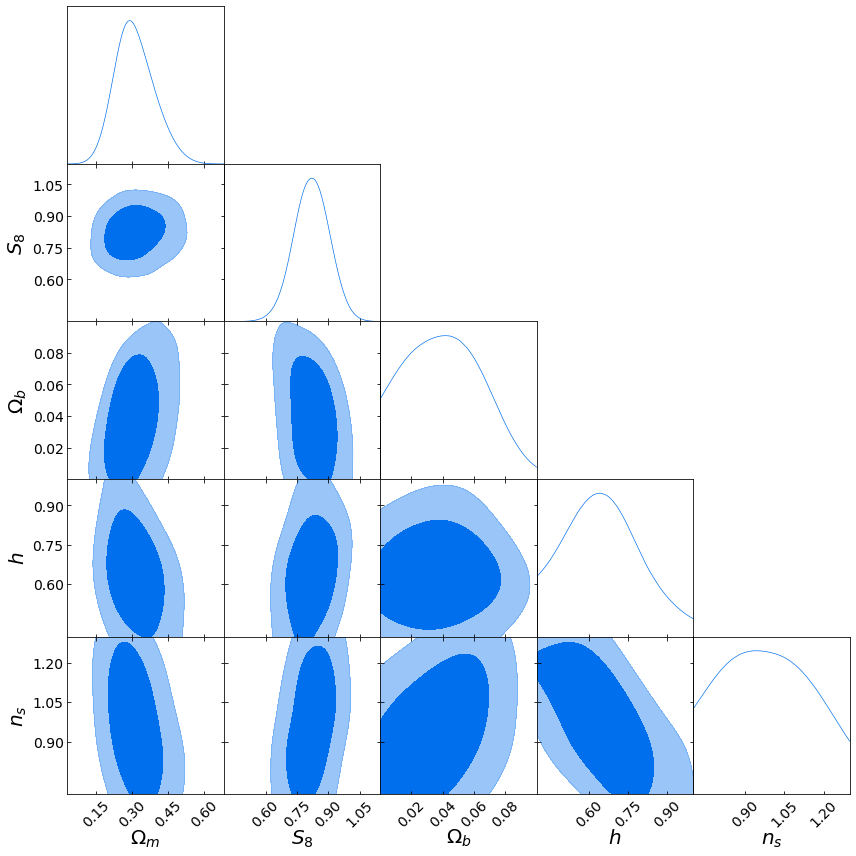

Population 12/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 60%|██████    | 300/500 [03:13<02:52,  1.16it/s]

Simulator returns exception for parameter values: [0.13939935 0.78396568 0.03656139 0.8437841  1.11097695] (rank 0)
Simulator returns exception for parameter values: [0.13939935 0.78396568 0.03656139 0.8437841  1.11097695] (rank 0)
Simulator returns exception for parameter values: [0.14199673 0.78047181 0.03755251 0.82137184 1.12085969] (rank 0)


 64%|██████▍   | 321/500 [03:34<03:13,  1.08s/it]

Simulator returns exception for parameter values: [0.15745912 0.8234378  0.03931276 0.70025405 1.25009745] (rank 0)
Simulator returns exception for parameter values: [0.15745912 0.8234378  0.03931276 0.70025405 1.25009745] (rank 0)
Simulator returns exception for parameter values: [0.15745912 0.8234378  0.03931276 0.70025405 1.25009745] (rank 0)
Simulator returns exception for parameter values: [0.1584102  0.83859016 0.03928618 0.71604941 1.25640423] (rank 0)
Simulator returns exception for parameter values: [0.1584102  0.83859016 0.03928618 0.71604941 1.25640423] (rank 0)
Simulator returns exception for parameter values: [0.1584102  0.83859016 0.03928618 0.71604941 1.25640423] (rank 0)
Simulator returns exception for parameter values: [0.1584102  0.83859016 0.03928618 0.71604941 1.25640423] (rank 0)
Simulator returns exception for parameter values: [0.16372461 0.84271748 0.0381055  0.71678112 1.23522706] (rank 0)


 67%|██████▋   | 337/500 [03:50<01:26,  1.89it/s]

Simulator returns exception for parameter values: [0.13881522 0.92996604 0.01608012 0.74572877 1.27305353] (rank 0)
Simulator returns exception for parameter values: [0.18430045 0.89639752 0.02436239 0.77156959 1.1226259 ] (rank 0)
Simulator returns exception for parameter values: [0.18430045 0.89639752 0.02436239 0.77156959 1.1226259 ] (rank 0)
Simulator returns exception for parameter values: [0.17029806 0.92294224 0.02255236 0.81644809 1.16554299] (rank 0)


 68%|██████▊   | 342/500 [03:55<01:57,  1.34it/s]

Simulator returns exception for parameter values: [0.17820352 0.88495184 0.02276745 0.73557246 1.19385806] (rank 0)
Simulator returns exception for parameter values: [0.17820352 0.88495184 0.02276745 0.73557246 1.19385806] (rank 0)
Simulator returns exception for parameter values: [0.17820352 0.88495184 0.02276745 0.73557246 1.19385806] (rank 0)


100%|██████████| 500/500 [05:18<00:00,  1.96it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_12.pdf


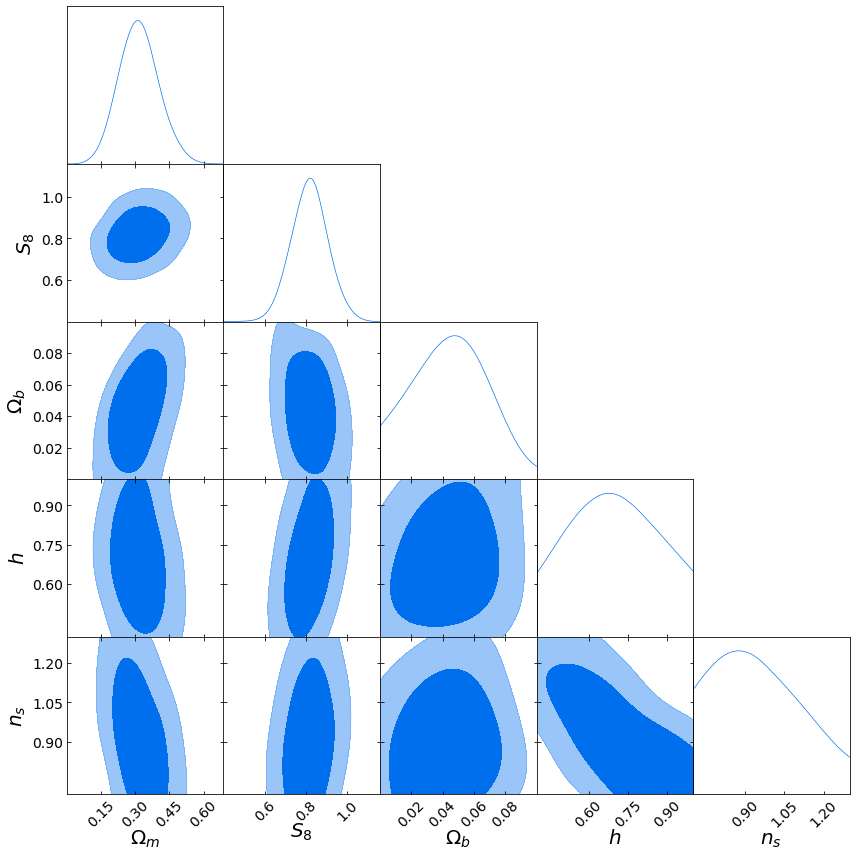

Population 13/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 32%|███▏      | 160/500 [01:32<03:10,  1.79it/s]

Simulator returns exception for parameter values: [0.14002409 0.79017468 0.01158717 0.89134066 0.80791755] (rank 0)
Simulator returns exception for parameter values: [0.13315678 0.79075798 0.00874328 0.89412452 0.80567531] (rank 0)
Simulator returns exception for parameter values: [0.13315678 0.79075798 0.00874328 0.89412452 0.80567531] (rank 0)
Simulator returns exception for parameter values: [0.13315678 0.79075798 0.00874328 0.89412452 0.80567531] (rank 0)
Simulator returns exception for parameter values: [0.12893    0.80026081 0.00581963 0.90504925 0.79382853] (rank 0)
Simulator returns exception for parameter values: [0.1253731  0.79725033 0.00573796 0.91450883 0.78125253] (rank 0)
Simulator returns exception for parameter values: [0.1253731  0.79725033 0.00573796 0.91450883 0.78125253] (rank 0)
Simulator returns exception for parameter values: [0.1253731  0.79725033 0.00573796 0.91450883 0.78125253] (rank 0)


 80%|████████  | 401/500 [04:01<00:59,  1.65it/s]

Simulator returns exception for parameter values: [0.20243736 0.93410392 0.00926434 0.56537807 1.1286324 ] (rank 0)


 84%|████████▎ | 418/500 [04:20<01:43,  1.26s/it]

Simulator returns exception for parameter values: [0.1814603  0.80901437 0.00973787 0.60733025 0.96032894] (rank 0)
Simulator returns exception for parameter values: [0.18087887 0.80812217 0.00931128 0.6067041  0.95782075] (rank 0)


100%|██████████| 500/500 [05:48<00:00,  1.22s/it]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_13.pdf


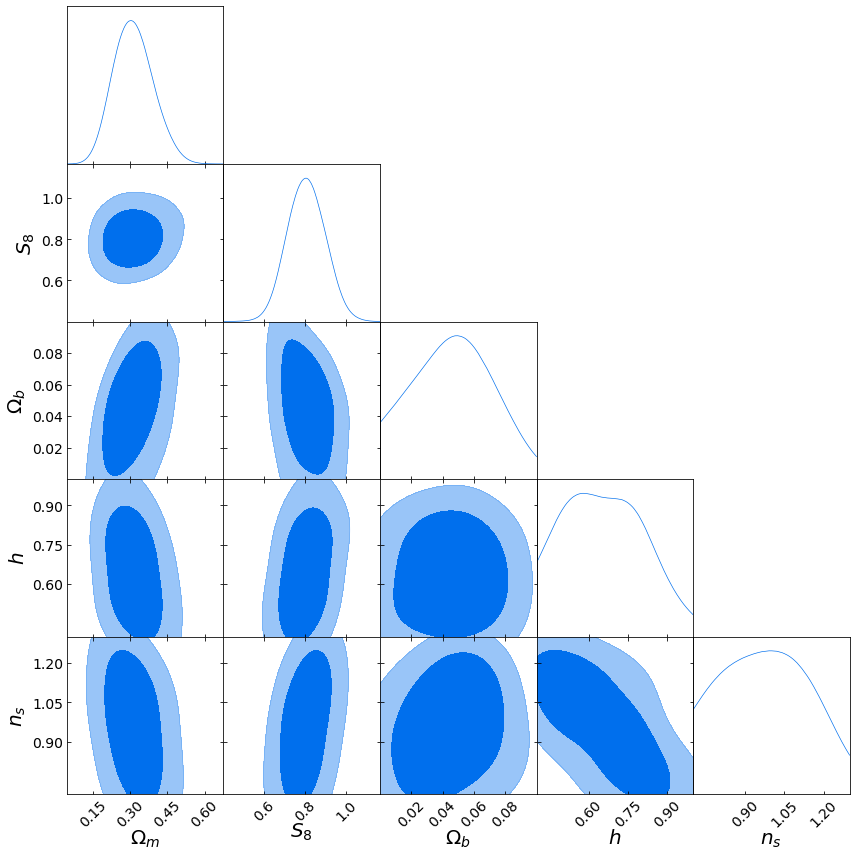

Population 14/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


100%|██████████| 500/500 [05:28<00:00,  1.82it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_14.pdf


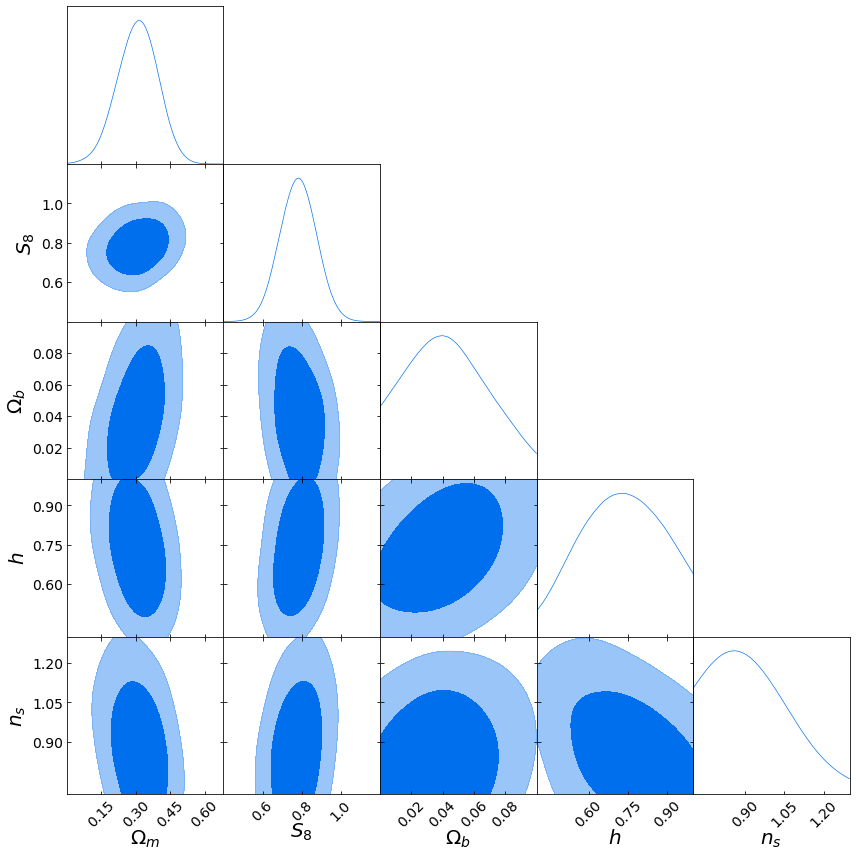

Population 15/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 95%|█████████▌| 475/500 [05:26<00:14,  1.73it/s]

Simulator returns exception for parameter values: [0.19499218 0.94499888 0.03924974 0.95525641 0.89417356] (rank 0)
Simulator returns exception for parameter values: [0.19499218 0.94499888 0.03924974 0.95525641 0.89417356] (rank 0)
Simulator returns exception for parameter values: [0.19499218 0.94499888 0.03924974 0.95525641 0.89417356] (rank 0)
Simulator returns exception for parameter values: [0.19499218 0.94499888 0.03924974 0.95525641 0.89417356] (rank 0)


 98%|█████████▊| 492/500 [05:37<00:04,  1.94it/s]

Simulator returns exception for parameter values: [0.14825739 0.98819107 0.00592306 0.87622261 1.05309203] (rank 0)
Simulator returns exception for parameter values: [0.15079434 0.98603738 0.00628184 0.87394585 1.05087552] (rank 0)
Simulator returns exception for parameter values: [0.11881912 1.05403326 0.00526964 0.96674584 1.08357427] (rank 0)
Simulator returns exception for parameter values: [0.11881912 1.05403326 0.00526964 0.96674584 1.08357427] (rank 0)


100%|██████████| 500/500 [05:42<00:00,  1.93it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_15.pdf


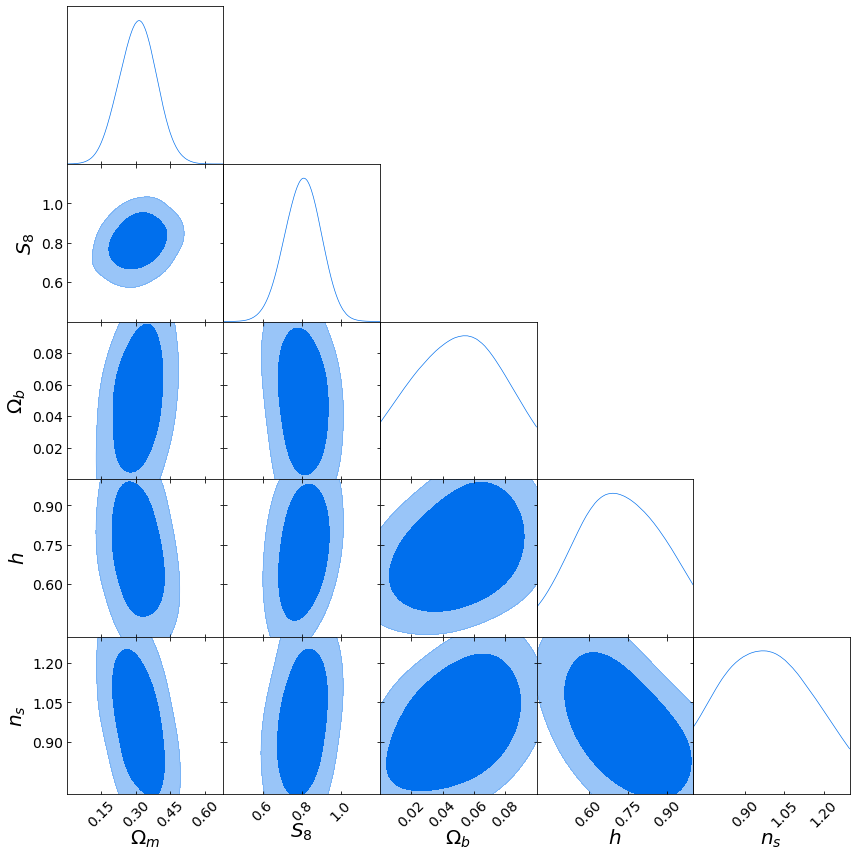

Final round of training with larger SGD batch size...



Done.
Sampling approximate posterior...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)


Done.
Saving seq_train_post_final.pdf


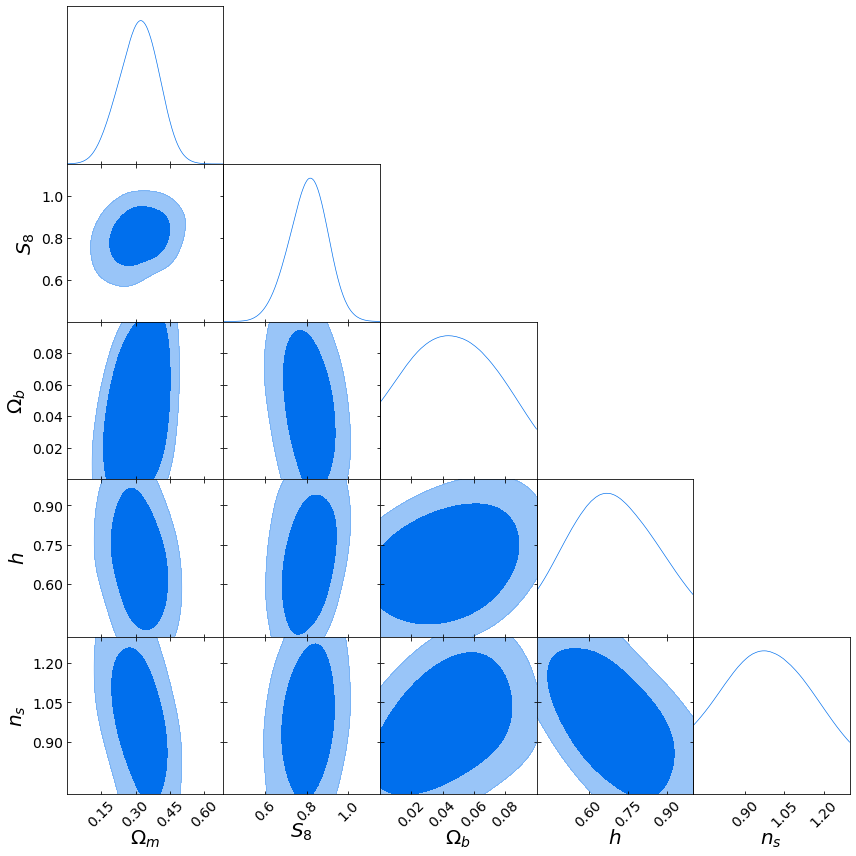

In [19]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*np.linalg.inv(n.sess.run(n.test_F)), lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 15

# Do the SNL training
mdn.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, proposal, epsilon = 1e-37, simulator_args=simulator_args, compressor_args=compressor_args)

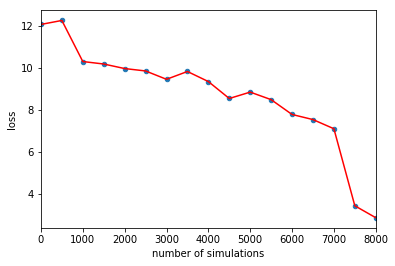

In [20]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()